# `Extrinsic Calibration` mounted on robot arm

In [156]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import *
from util import *
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


##### parsing `UR5e`

In [157]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


##### Camera view `following robot arm`

[0/7] obj_name:[obj_cylinder_1]
[1/7] obj_name:[obj_cylinder_2]
[2/7] obj_name:[obj_cylinder_3]
[3/7] obj_name:[obj_cylinder_1_thick]
[4/7] obj_name:[obj_cylinder_2_thick]
[5/7] obj_name:[obj_cylinder_3_thick]
[6/7] obj_name:[obj_box_1]


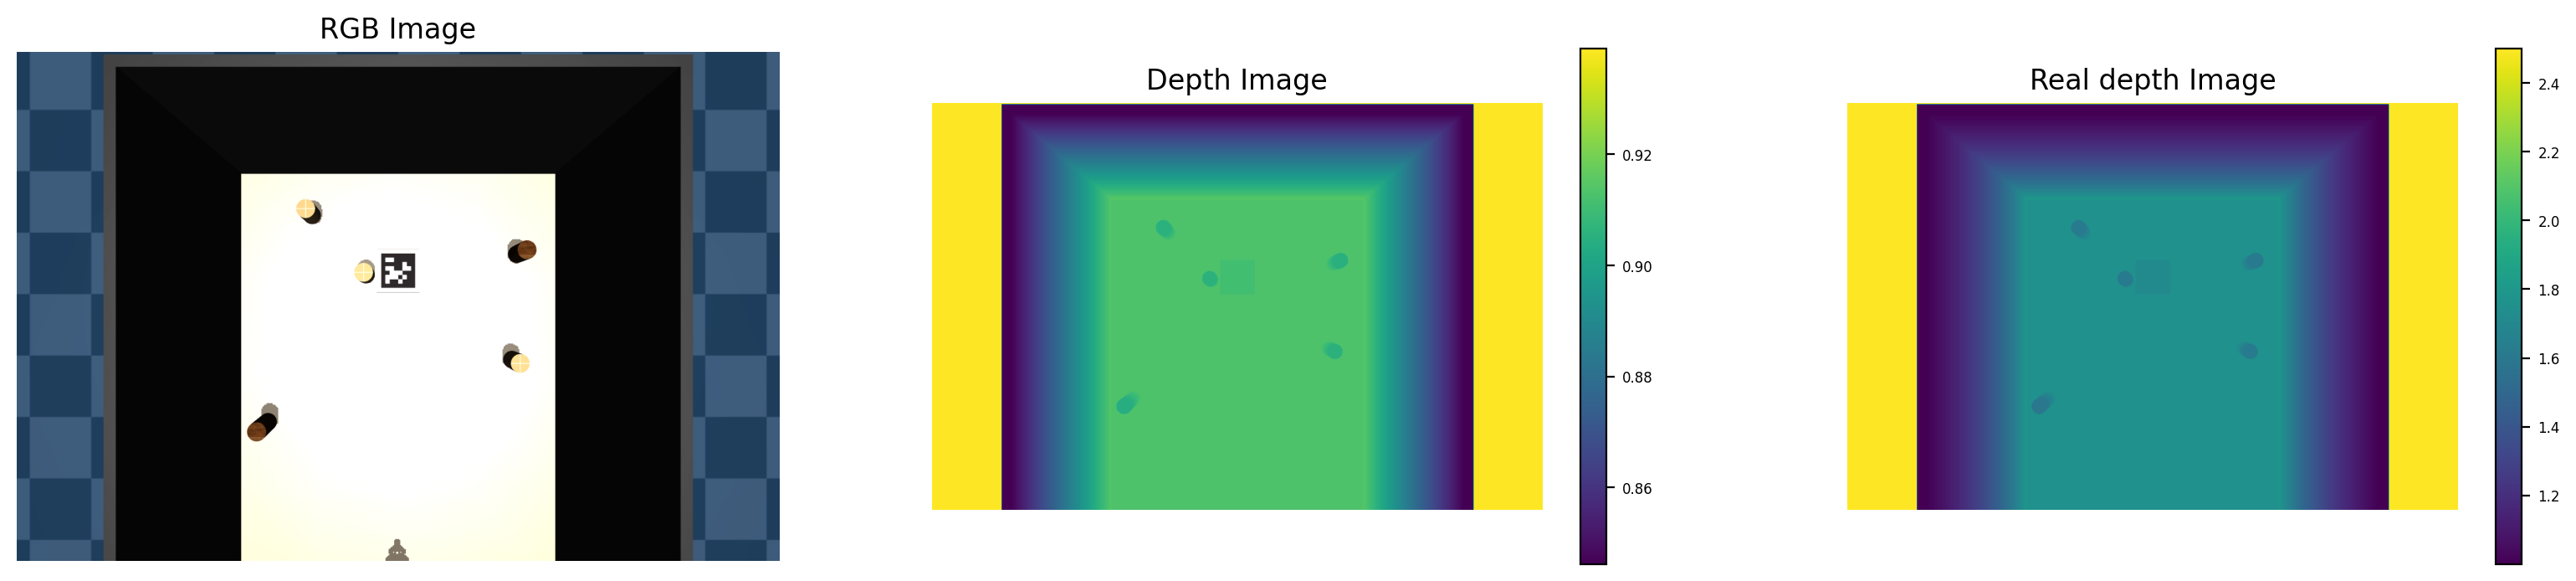

In [158]:
import math

# Get camera information
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.2,0.0,2.5])

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

# Check available objects whose names start with 'obj_'
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))

# Randomly initialize position of objects.
random_spawn_objects(env, prefix='obj_')

# Set Joint Configurations
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2 ]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# update object, robot configurations
env.forward(INCREASE_TICK=False)

width = 1500
height = 1000
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)


for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth_2_meters(img_depth))

plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
plt.imshow(img); plt.axis('off')
plt.title("RGB Image")
# plt.show()

plt.subplot(1, 3, 2)
plt.imshow(img_depth); plt.axis('off')
plt.title("Depth Image")
plt.colorbar()
# plt.show()

plt.subplot(1, 3, 3)
plt.imshow(img_real); plt.axis('off')
plt.title("Real depth Image")
plt.colorbar()
plt.show()

##### get Rotational, Translational informations of wrist

In [159]:
wrist2_rot = env.sim.data.get_body_xmat("ur_wrist_2_link")
print(wrist2_rot)  # represented in R

wrist3_rot = env.sim.data.get_body_xmat("ur_wrist_3_link")
print(wrist3_rot)  # represented in R

wrist2_pos = env.sim.data.get_body_xpos("ur_wrist_2_link")
print(wrist2_pos)

wrist3_pos = env.sim.data.get_body_xpos("ur_wrist_3_link")
print(wrist3_pos)

wrist2_rot_rpy = np.degrees(r2rpy(wrist2_rot))
print(wrist2_rot_rpy)

wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))
print(wrist3_rot_rpy)

[[ 7.07e-01  7.07e-01 -5.55e-17]
 [ 1.67e-16 -9.71e-17  1.00e+00]
 [ 7.07e-01 -7.07e-01 -2.36e-16]]
[[ 2.78e-17  7.07e-01 -7.07e-01]
 [ 1.00e+00 -1.39e-16  0.00e+00]
 [-1.67e-16 -7.07e-01 -7.07e-01]]
[ 0.29 -0.09  1.18]
[0.29 0.   1.18]
[-9.00e+01 -4.50e+01  1.35e-14]
[-1.35e+02  9.54e-15  9.00e+01]


In [160]:
# Get camera information
cam_infos = env.set_cam_infos(cam_distance  = 0.,
                    cam_azimuth   = wrist3_rot_rpy[2]+90,  # Z-axis: Yaw
                    cam_elevation = wrist3_rot_rpy[0],  # X-axis: Roll
                    cam_lookat    = wrist3_pos) 

# Get `AX=XB` matrix data

## Get matrix `A`: Detected AprilTag pose

In [161]:
import apriltag

def get_apriltag_pose(img):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about A that represents detected AprilTag pose in camera coordinate.
    """
    detector = apriltag.Detector()
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    # detections, dimg = detector.detect(fram_gray, return_image=True)
    results = detector.detect(img_Gray)

    # cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_width, height=env.render_height, camera_name="main1")
    cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_height, height=env.render_width, camera_name="main1")

    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    cam_params = [fx, fy, cx, cy]

    # Render the detections on the image
    if len(results) > 0:
        draw_bbox(results, img, verbose=False)

        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)    # should check tag_size
            
            poseRotation = pose[:3, :3]
            poseTranslation = pose[:3, 3]

        return pose

    else:   # if any detected marker is none, return None.
        return None

get_apriltag_pose(img)

array([[-0.01,  1.  , -0.05,  0.22],
       [-1.  , -0.01, -0.05, -0.29],
       [-0.05,  0.05,  1.  ,  1.63],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

## Get matrix `B`: Transformation operations about robot links

In [162]:
def get_env_body_names(env,prefix='ur_'):
    """
        Accumulate robot body names by assuming that the prefix is 'ur_'
    """
    body_names = [x for x in env.body_names if x[:len(prefix)]==prefix]

    return body_names
    
get_env_body_names(env)

['ur_base_link',
 'ur_shoulder_link',
 'ur_upper_arm_link',
 'ur_forearm_link',
 'ur_wrist_1_link',
 'ur_wrist_2_link',
 'ur_wrist_3_link']

In [198]:
def get_base2ee_matrix(env, link_prefix='ur_', verbose=False):
    """
        In AX=XB Equation, (extrinsic calibration) 
        Get matrix about B that represents transformation matrix [Robot base to Robot End-Effector].
    """
    # ur_links = ['ur_base_link', 'ur_shoulder_link', 'ur_upper_arm_link', 'ur_forearm_link', 'ur_wrist_1_link', 'ur_wrist_2_link', 'ur_wrist_3_link']

    link_names = get_env_body_names(env, link_prefix)
    T_links = []

    for idx, link in enumerate(link_names):
        if verbose == True:
            print(link)
        p_link = env.get_p_body(body_name=link)  # 3x3
        R_link = env.get_R_body(body_name=link)  # 3x1
        # T_link = pr2t(p_link, R_link)
        T_link = cv2.hconcat((R_link, p_link))      # 3x4
        T_link = np.vstack((T_link, np.array([0,0,0,1])))   # 4x4
        
        T_links.append(T_link)

    for i in range(len(T_links)-1):
        T_bs2end = np.matmul(T_links[i], T_links[i+1])
    
    return T_bs2end

ur_links = ['ur_base_link', 'ur_shoulder_link', 'ur_upper_arm_link', 'ur_forearm_link', 'ur_wrist_1_link', 'ur_wrist_2_link', 'ur_wrist_3_link']

bs2ee_matrix = get_base2ee_matrix(env, 'ur_')
bs2ee_matrix

array([[-5.28e-01, -7.21e-01,  4.48e-01,  1.94e+00],
       [ 3.08e-33, -5.28e-01, -8.49e-01, -1.05e+00],
       [ 8.49e-01, -4.48e-01,  2.79e-01,  2.09e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])

In [185]:
p_eef = env.get_p_body("rg2_gripper_base_link")
box_april_pos = env.sim.data.get_body_xpos("box_checker")


In [186]:
T_viewer, T_lookat = get_viewer_coordinate(cam_infos["cam_lookat"], cam_infos["cam_distance"], cam_infos["cam_elevation"], cam_infos["cam_azimuth"])

In [187]:
T_viewer

array([[ 0.53,  0.  ,  0.85,  1.03],
       [ 0.  ,  1.  ,  0.  , -0.11],
       [-0.85,  0.  ,  0.53,  1.37],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [188]:
T_lookat

array([[ 0.53,  0.  ,  0.85,  1.03],
       [ 0.  ,  1.  ,  0.  , -0.11],
       [-0.85,  0.  ,  0.53,  1.37],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

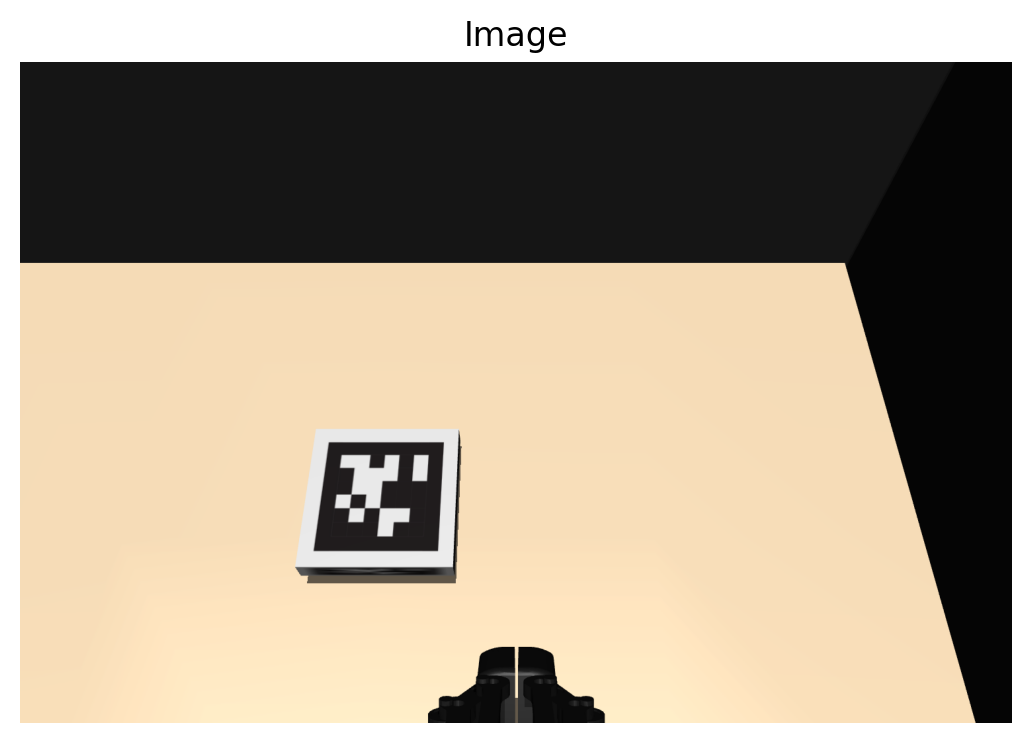

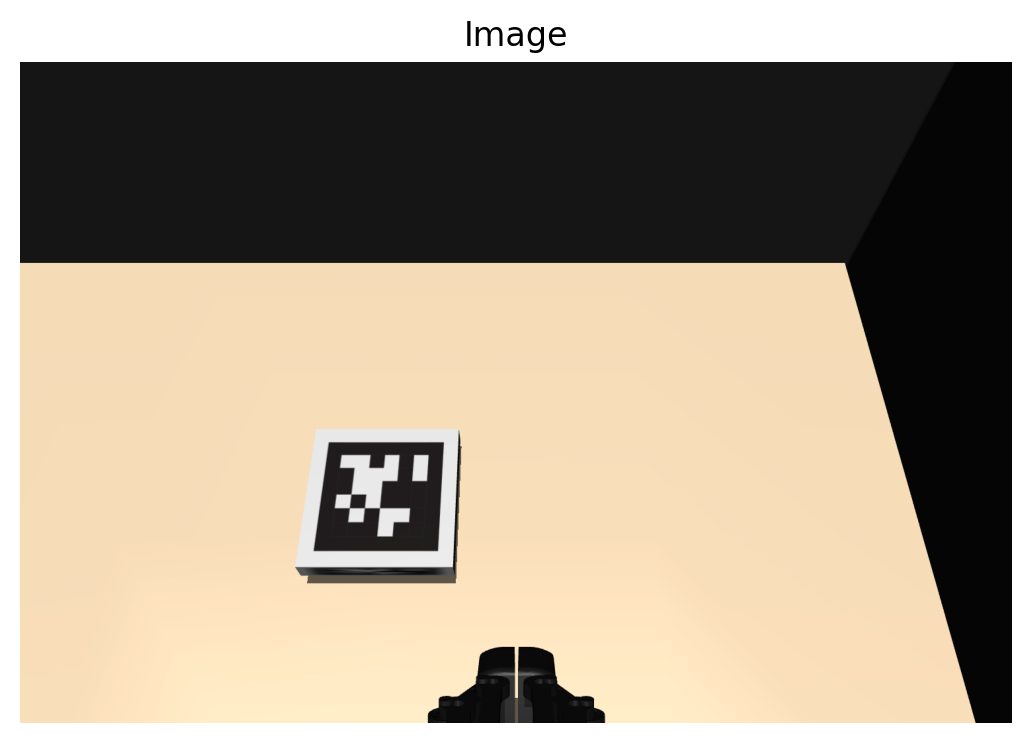

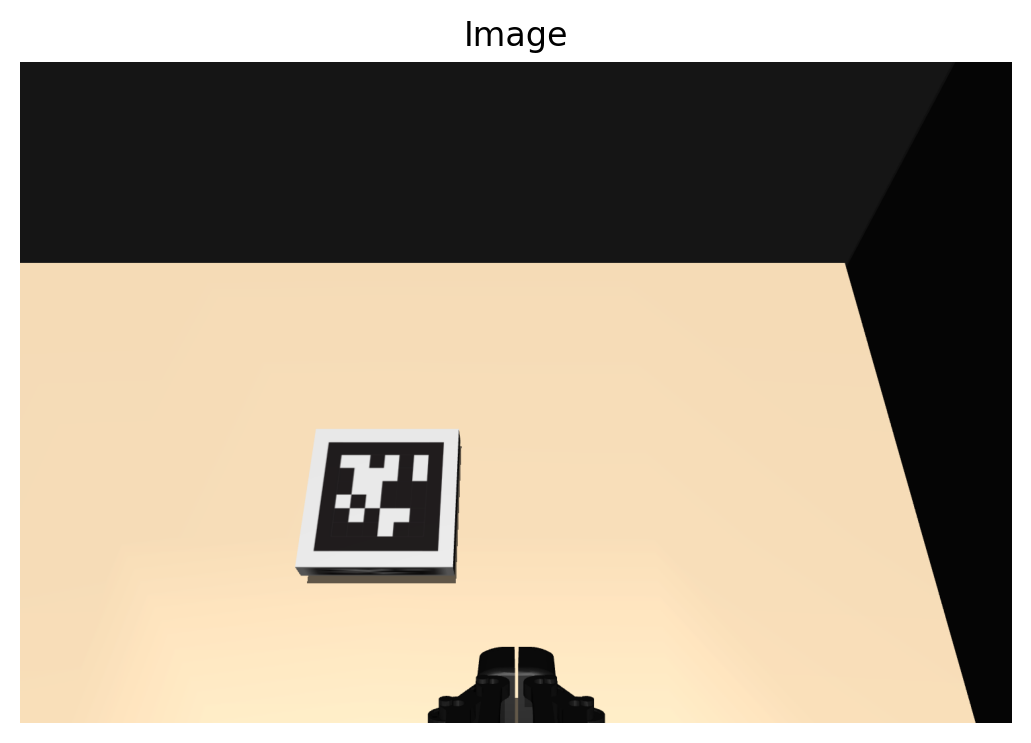

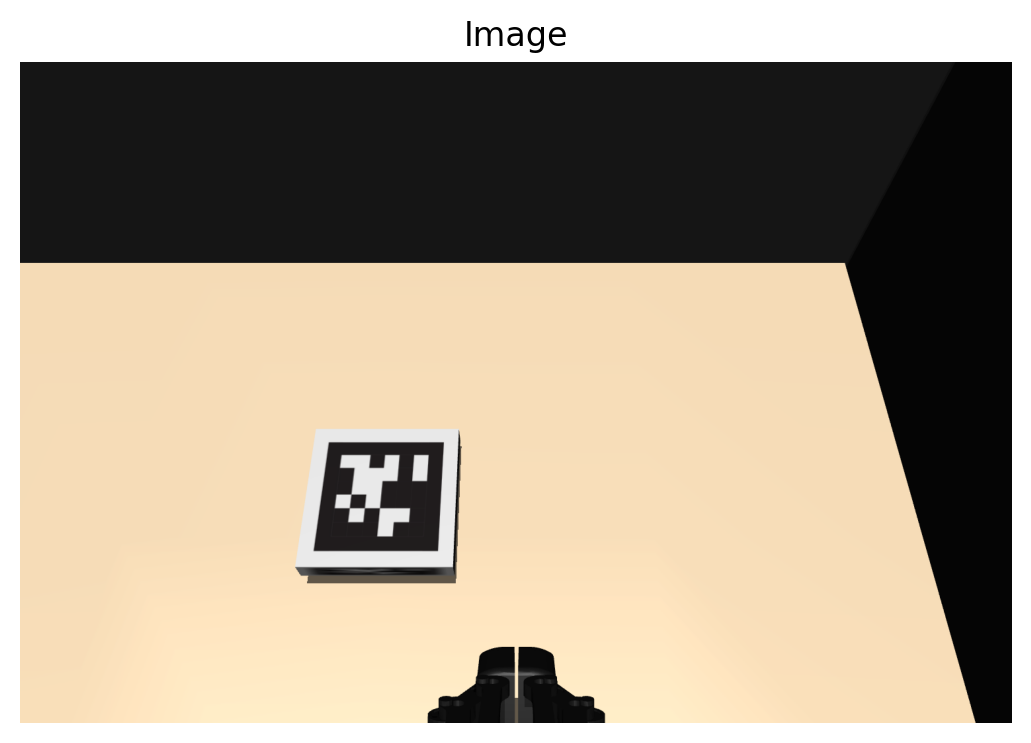

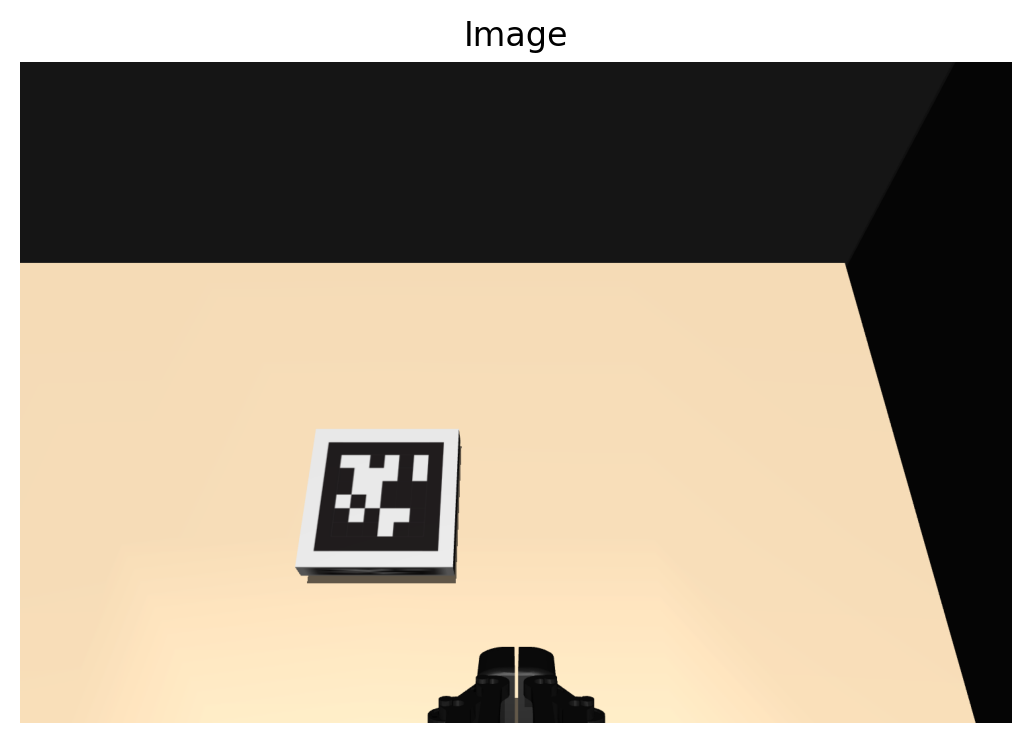

In [189]:
import apriltag

frames = []
poses = []              # apriltag pose list
bs2ee_matrix_list = []  # base to endeffector matrix list

# Set objects behind of apriltag
obj_names = get_env_obj_names(env,prefix='obj_') # see objects

for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.7,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=None)

max_tick = 5
env.tick = 0

while env.tick < max_tick:
    # Set AprilTag configurations
    april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
    env.sim.data.qpos[april_addr_z] = -math.pi/2

    # Update
    env.step()
   
    # Set Joint Configurations
    init_configurations = [-math.pi, -3*math.pi/4, -0.5, -1.3, math.pi/2, 0]
    set_env_joint_configuration(env, init_configurations, prefix='ur_')

    # Get wrist pose.
    p_eef = env.get_p_body("rg2_gripper_base_link")
    R_eef = env.get_R_body("rg2_gripper_base_link")

    wrist3_rot = env.sim.data.get_body_xmat("ur_wrist_3_link")
    wrist3_pos = env.sim.data.get_body_xpos("rg2_gripper_base_link")
    wrist3_rot_rpy = np.degrees(r2rpy(wrist3_rot))

    # Follow Robot wrist #3.
    cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                        cam_azimuth   = wrist3_rot_rpy[2]+90,  # Z-axis: Yaw
                        cam_elevation = wrist3_rot_rpy[0],  # X-axis: Roll                        
                        cam_lookat    = p_eef+[0.05, 0, 0.10])   # arbitrary offset on camera.

    # # Get image
    # for rc_idx in range(len(env.sim.render_contexts)):
    #     env.sim.render_contexts[rc_idx].cam.lookat[0] = cam_infos["cam_lookat"][0]
    #     env.sim.render_contexts[rc_idx].cam.lookat[1] = cam_infos["cam_lookat"][1]
    #     env.sim.render_contexts[rc_idx].cam.lookat[2] = cam_infos["cam_lookat"][2]
    #     env.sim.render_contexts[rc_idx].cam.distance  = cam_infos["cam_distance"]
    #     env.sim.render_contexts[rc_idx].cam.azimuth   = cam_infos["cam_azimuth"]
    #     env.sim.render_contexts[rc_idx].cam.elevation = cam_infos["cam_elevation"]

    # update object, robot configurations
    env.forward(INCREASE_TICK=False)

    for _ in range(10):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=False, camera_name="track")
        img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=env.render_width, height=env.render_height, depth_toggle=True, camera_name="track")
        img_real = np.array(env.depth_2_meters(img_depth))

    plt.imshow(img); plt.axis('off')
    plt.title("Image")
    plt.show()

    frames.append(img)
    pose = get_apriltag_pose(img)

    # if there is any detected apriltag marker, then stroe the matrices.
    poses.append(pose)
    bs2ee_matrix = get_base2ee_matrix(env, 'ur_')
    bs2ee_matrix_list.append(bs2ee_matrix)

display_frames_as_gif(frames, "test-calibration-following-11.gif")

##### compare apriltag positions

In [192]:
cam_lookat = cam_infos["cam_lookat"]
print(cam_lookat)

box_april_pos = env.sim.data.get_body_xpos("box_checker")
print(box_april_pos)

print(f"Ground-Truth AprilTag position: {cam_lookat - box_april_pos}")
print(f"Estimated AprilTag position: {poses[-1][:3,3]}")

[ 1.03 -0.11  1.37]
[1.3  0.   0.77]
Ground-Truth AprilTag position: [-0.27 -0.11  0.6 ]
Estimated AprilTag position: [ 0.01 -0.03  0.59]


In [167]:
# Get image
for rc_idx in range(len(env.sim.render_contexts)):
    print(rc_idx)
    env.sim.render_contexts[rc_idx].cam.lookat[0] = cam_lookat[0]
    env.sim.render_contexts[rc_idx].cam.lookat[1] = cam_lookat[1]
    env.sim.render_contexts[rc_idx].cam.lookat[2] = cam_lookat[2]
    env.sim.render_contexts[rc_idx].cam.distance  = cam_infos["cam_distance"]
    env.sim.render_contexts[rc_idx].cam.azimuth   = cam_infos["cam_azimuth"]
    env.sim.render_contexts[rc_idx].cam.elevation = cam_infos["cam_elevation"]


0


In [168]:
print(dir(env.sim.render_contexts))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [169]:
print(dir(env.sim.render_contexts[0].cam))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'azimuth', 'distance', 'elevation', 'fixedcamid', 'lookat', 'trackbodyid', 'type', 'uintptr']


In [170]:
env.sim.render_contexts[0].cam.type

0